<ipython-input-18-869a09669035>:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


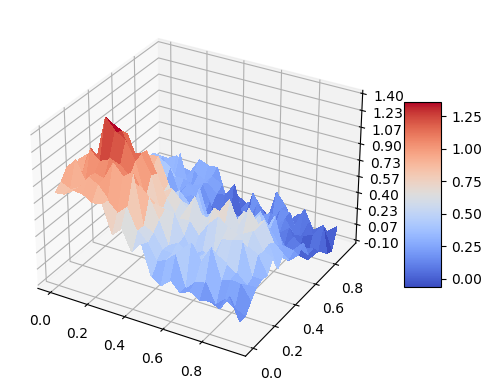

In [18]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model

fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))

    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

#z is the sum of the franke function and the noise, that's made with a normal distribution. We multiplied it by 0.1 to make it smoother.
z = FrankeFunction(x, y) + 0.1*np.random.normal(0,1, x.shape)
# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [19]:
#create design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X


In [20]:
#define parameters and making the matrix permanent
n=5
N=len(x)
X=create_X(x,y,n)

In [21]:
# split in training and test data
X_train, X_test, z_train, z_test = train_test_split(X,z.reshape(-1,1).ravel(),test_size=0.2)

In [22]:
#OLS
betaOLS = (np.linalg.inv(X_train.T @ X_train) @ X_train.T ) @ z_train
# and then make the prediction
ztildeOLS = X_train @ betaOLS

zpredictOLS = X_test @ betaOLS

In [23]:
#MSE and R2
print("MSE train OLS: ")
print(MSE(z_train,ztildeOLS))
print("R2 train OLS: ")
print(R2(z_train,ztildeOLS))
print("MSE test OLS: ")
print(MSE(z_test,zpredictOLS))
print("R2 test OLS: ")
print(R2(z_test,zpredictOLS))

MSE train OLS: 
0.011382026068132925
R2 train OLS: 
0.8850243803464037
MSE test OLS: 
0.013239776982904312
R2 test OLS: 
0.8652228882363601


In [24]:
#we delete the first column of 
X_=X[:,1:]

In [25]:
# split in training and test data
X_train, X_test, z_train, z_test = train_test_split(X_,z.reshape(-1,1).ravel(),test_size=0.2)

In [26]:
z.shape

(20, 20)

In [27]:
#For our own implementation, we will need to deal with the intercept by centering the design matrix and the target variable
X_train_mean = np.mean(X_train,axis=0)
#Center by removing mean from each feature
X_train_scaled = X_train - X_train_mean 
X_test_scaled = X_test - X_train_mean
#The model intercept (called z_scaler) is given by the mean of the target variable (IF X is centered)
#Remove the intercept from the training data.
z_scaler = np.mean(z_train)           
z_train_scaled = z_train - z_scaler

In [28]:
#OLS point a)
betaOLS = (np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T ) @ z_train_scaled
interceptOLS = z_scaler - X_train_mean @ betaOLS
# and then make the prediction
ztildeOLS = X_train_scaled @ betaOLS + z_scaler

zpredictOLS = X_test_scaled @ betaOLS + z_scaler

In [29]:
#MSE and R2
print("MSE train OLS: ")
print(MSE(z_train,ztildeOLS))
print("R2 train OLS: ")
print(R2(z_train,ztildeOLS))
print("MSE test OLS: ")
print(MSE(z_test,zpredictOLS))
print("R2 test OLS: ")
print(R2(z_test,zpredictOLS))
#it makes sense to scale, we can see it just by looking at the MSE and R2 for the non scaled/scaled.

MSE train OLS: 
0.011680686254281451
R2 train OLS: 
0.8806769436397185
MSE test OLS: 
0.01276620411930629
R2 test OLS: 
0.8756442861407092


Beta values for Ridge implementation
[  2.80113109   2.92761866 -12.65664746  -1.04852656 -10.49005983
   8.53803244   9.82543564   1.47888798   1.78470268   9.13173283
 -12.78623442   9.65447224 -15.42088775  17.05778736  -8.55740732
   1.2932153    5.89633967 -12.41856683  13.85449826 -11.98594282]
Intercept from implementation:
0.7157284429750475
MSE values for train Ridge implementation
0.012091362978240164
MSE values for test Ridge implementation
0.013526537434433375
R2 values for train Ridge implementation
0.876481710516252
R2 values for test Ridge implementation
0.8682378721988673
Beta values for Ridge implementation
[ 0.07927919  1.00727976 -3.31915428  1.34124423 -4.42840439  1.94113878
  1.29703804 -1.51401118  0.91846795  2.01877431  0.7930932   0.21115265
 -0.46358001  2.32593668 -1.70614825 -1.51545021  0.17966338 -0.01782412
  0.13959948 -0.23407996]
Intercept from implementation:
0.9426675702719098
MSE values for train Ridge implementation
0.016916467162485776
MSE values

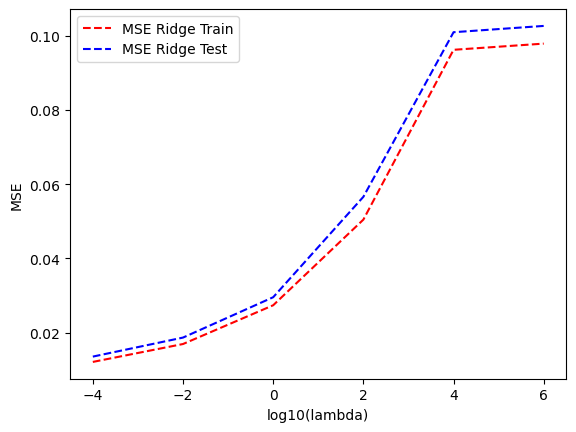

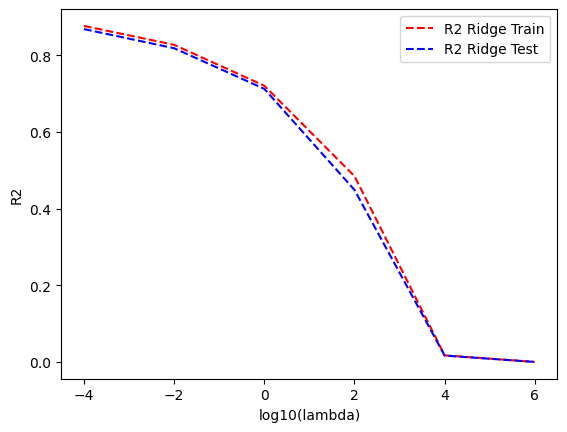

In [30]:
#Ridge regression, point b)
p=X_.shape[1]
I = np.eye(p,p)
# Decide which values of lambda to use
nlambdas = 6
MSETrainRidge = np.zeros(nlambdas)
MSETestRidge = np.zeros(nlambdas)
R2TrainRidge = np.zeros(nlambdas)
R2TestRidge = np.zeros(nlambdas)


lambdas = np.logspace(-4, 6, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    betaRidge = np.linalg.pinv(X_train_scaled.T @ X_train_scaled+lmb*I) @ X_train_scaled.T @ (z_train_scaled)
    intercept_ = z_scaler - X_train_mean@betaRidge #The intercept can be shifted so the model can predict on uncentered data
    #Add intercept to prediction
    ztildeRidge = X_train_scaled @ betaRidge + z_scaler 
    zpredictRidge = X_test_scaled @ betaRidge + z_scaler 
    MSETrainRidge[i] = MSE(z_train,ztildeRidge)
    MSETestRidge[i] = MSE(z_test,zpredictRidge)
    R2TrainRidge[i] = R2(z_train,ztildeRidge)
    R2TestRidge[i] = R2(z_test,zpredictRidge)
    print("Beta values for Ridge implementation")
    print(betaRidge) #Intercept is given by mean of target variable
    print('Intercept from implementation:')
    print(intercept_)
    print("MSE values for train Ridge implementation")
    print(MSETrainRidge[i])
    print("MSE values for test Ridge implementation")
    print(MSETestRidge[i])
    print("R2 values for train Ridge implementation")
    print(R2TrainRidge[i])
    print("R2 values for test Ridge implementation")
    print(R2TestRidge[i])


# Now plot the results MSE
plt.figure()
plt.plot(np.log10(lambdas), MSETrainRidge, 'r--', label = 'MSE Ridge Train')
plt.plot(np.log10(lambdas), MSETestRidge, 'b--', label = 'MSE Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Now plot the results R2
plt.figure()
plt.plot(np.log10(lambdas), R2TrainRidge, 'r--', label = 'R2 Ridge Train')
plt.plot(np.log10(lambdas), R2TestRidge, 'b--', label = 'R2 Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('R2')
plt.legend()
plt.show()

<ipython-input-31-2cdbf9fb7da5>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  RegLasso.fit(X_train_scaled,z_train_scaled)
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+00, tolerance: 3.133e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Beta values for Ridge implementation
[-0.31248117  1.187975   -2.70377171  1.88217477 -5.74283175  2.18472811
  1.96445882 -1.88166895  2.67853843  0.71649457 -0.44611708 -1.16064283
 -0.10344785  2.18538146 -0.87811209 -1.63379375  2.27061857 -0.4811891
  0.08153765 -0.77445966]
MSE values for train Lasso implementation
0.01685787291671171
MSE values for test Lasso implementation
0.0187890063216762
R2 values for train Lasso implementation
0.8277898338877182
R2 values for test Lasso implementation
0.8169761134944364


<ipython-input-31-2cdbf9fb7da5>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  RegLasso.fit(X_train_scaled,z_train_scaled)
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+00, tolerance: 3.133e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Beta values for Ridge implementation
[-0.31248117  1.187975   -2.70377171  1.88217477 -5.74283175  2.18472811
  1.96445882 -1.88166895  2.67853843  0.71649457 -0.44611708 -1.16064283
 -0.10344785  2.18538146 -0.87811209 -1.63379375  2.27061857 -0.4811891
  0.08153765 -0.77445966]
MSE values for train Lasso implementation
0.01685787291671171
MSE values for test Lasso implementation
0.0187890063216762
R2 values for train Lasso implementation
0.8277898338877182
R2 values for test Lasso implementation
0.8169761134944364


<ipython-input-31-2cdbf9fb7da5>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  RegLasso.fit(X_train_scaled,z_train_scaled)
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+00, tolerance: 3.133e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Beta values for Ridge implementation
[-0.31248117  1.187975   -2.70377171  1.88217477 -5.74283175  2.18472811
  1.96445882 -1.88166895  2.67853843  0.71649457 -0.44611708 -1.16064283
 -0.10344785  2.18538146 -0.87811209 -1.63379375  2.27061857 -0.4811891
  0.08153765 -0.77445966]
MSE values for train Lasso implementation
0.01685787291671171
MSE values for test Lasso implementation
0.0187890063216762
R2 values for train Lasso implementation
0.8277898338877182
R2 values for test Lasso implementation
0.8169761134944364


<ipython-input-31-2cdbf9fb7da5>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  RegLasso.fit(X_train_scaled,z_train_scaled)
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+00, tolerance: 3.133e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Beta values for Ridge implementation
[-0.31248117  1.187975   -2.70377171  1.88217477 -5.74283175  2.18472811
  1.96445882 -1.88166895  2.67853843  0.71649457 -0.44611708 -1.16064283
 -0.10344785  2.18538146 -0.87811209 -1.63379375  2.27061857 -0.4811891
  0.08153765 -0.77445966]
MSE values for train Lasso implementation
0.01685787291671171
MSE values for test Lasso implementation
0.0187890063216762
R2 values for train Lasso implementation
0.8277898338877182
R2 values for test Lasso implementation
0.8169761134944364


<ipython-input-31-2cdbf9fb7da5>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  RegLasso.fit(X_train_scaled,z_train_scaled)
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+00, tolerance: 3.133e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Beta values for Ridge implementation
[-0.31248117  1.187975   -2.70377171  1.88217477 -5.74283175  2.18472811
  1.96445882 -1.88166895  2.67853843  0.71649457 -0.44611708 -1.16064283
 -0.10344785  2.18538146 -0.87811209 -1.63379375  2.27061857 -0.4811891
  0.08153765 -0.77445966]
MSE values for train Lasso implementation
0.01685787291671171
MSE values for test Lasso implementation
0.0187890063216762
R2 values for train Lasso implementation
0.8277898338877182
R2 values for test Lasso implementation
0.8169761134944364


<ipython-input-31-2cdbf9fb7da5>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  RegLasso.fit(X_train_scaled,z_train_scaled)
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+00, tolerance: 3.133e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Beta values for Ridge implementation
[-0.31248117  1.187975   -2.70377171  1.88217477 -5.74283175  2.18472811
  1.96445882 -1.88166895  2.67853843  0.71649457 -0.44611708 -1.16064283
 -0.10344785  2.18538146 -0.87811209 -1.63379375  2.27061857 -0.4811891
  0.08153765 -0.77445966]
MSE values for train Lasso implementation
0.01685787291671171
MSE values for test Lasso implementation
0.0187890063216762
R2 values for train Lasso implementation
0.8277898338877182
R2 values for test Lasso implementation
0.8169761134944364


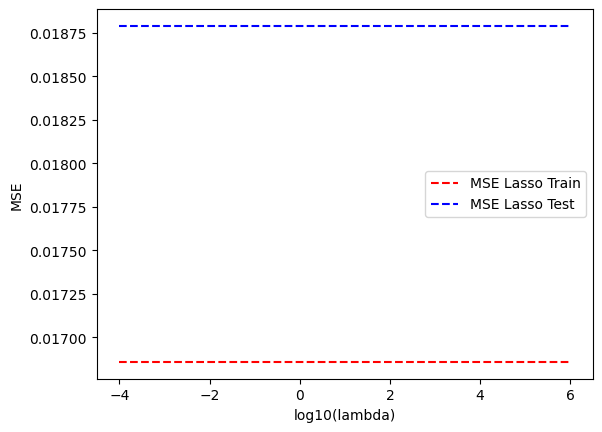

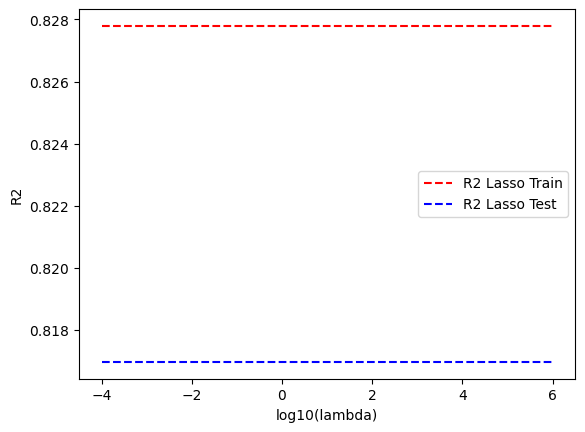

In [31]:
#Lasso regression, point c)
MSETrainLasso = np.zeros(nlambdas)
MSETestLasso = np.zeros(nlambdas)
R2TrainLasso = np.zeros(nlambdas)
R2TestLasso = np.zeros(nlambdas)

#m.k.o.kvalsund@fys,uio,no
lambdas = np.logspace(-4, 6, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    RegLasso = linear_model.Lasso(0,fit_intercept=True) 
    RegLasso.fit(X_train_scaled,z_train_scaled)
    zpredictLasso = RegLasso.predict(X_test_scaled) + z_scaler
    ztildeLasso = RegLasso.predict(X_train_scaled) + z_scaler
    MSETrainLasso[i] = MSE(z_train,ztildeLasso)
    MSETestLasso[i] = MSE(z_test,zpredictLasso)
    R2TrainLasso[i] = R2(z_train,ztildeLasso)
    R2TestLasso[i] = R2(z_test,zpredictLasso)
    print("Beta values for Ridge implementation")
    print(RegLasso.coef_)
    print("MSE values for train Lasso implementation")
    print(MSETrainLasso[i])
    print("MSE values for test Lasso implementation")
    print(MSETestLasso[i])
    print("R2 values for train Lasso implementation")
    print(R2TrainLasso[i])
    print("R2 values for test Lasso implementation")
    print(R2TestLasso[i])


# Now plot the results MSE
plt.figure()
plt.plot(np.log10(lambdas), MSETrainLasso, 'r--', label = 'MSE Lasso Train')
plt.plot(np.log10(lambdas), MSETestLasso, 'b--', label = 'MSE Lasso Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Now plot the results R2
plt.figure()
plt.plot(np.log10(lambdas), R2TrainLasso, 'r--', label = 'R2 Lasso Train')
plt.plot(np.log10(lambdas), R2TestLasso, 'b--', label = 'R2 Lasso Test')
plt.xlabel('log10(lambda)')
plt.ylabel('R2')
plt.legend()
plt.show()